# Toxic comments with BERT 🤬

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель проекта:** Обучить модель классифицировать комментарии на позитивные и негативные.

Целевая метрика: `F1 >= 0.75`

**Содержание**<a id='toc0_'></a>    
1. [ Подготовка       ](#toc1_)    
1.1. [Библиотеки       ](#toc1_1_)    
1.2. [Конфигурация       ](#toc1_2_)    
1.3. [Сервисные функции       ](#toc1_3_)    
2. [Данные       ](#toc2_)    
2.1. [Загрузка       ](#toc2_1_)    
2.2. [Проверка типов данных       ](#toc2_2_)    
2.3. [Проверка пропусков       ](#toc2_3_)    
2.4. [Проверка полных дубликатов       ](#toc2_4_)    
2.5. [Изучение таргета       ](#toc2_5_)    
2.6. [Выводы по датасету       ](#toc2_6_)    
3. [Обработка текста       ](#toc3_)    
4. [Модели       ](#toc4_)    
4.1. [Разделение данных       ](#toc4_1_)    
4.2. [Подготовка      ](#toc4_2_)    
4.3. [Модель `LogisticRegression`      ](#toc4_3_)    
4.4. [Модель `RandomForestClassifier`     ](#toc4_4_)    
4.5. [Модель `LGBMClassifier`     ](#toc4_5_)    
4.6. [Модель `CatBoostClassifier`     ](#toc4_6_)    
4.7. [Модель `BERT`  ](#toc4_7_)    
4.8. [Модель `toxic-BERT` ](#toc4_8_)    
5. [Результаты     ](#toc5_)    
5.1. [Результаты на тренировочной выборке     ](#toc5_1_)    
5.2. [Результаты на тестовой выборке     ](#toc5_2_)    
6. [Общий вывод     ](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a> Подготовка        [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки        [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
%pip install -q accelerate==0.26.0
%pip install -q catboost==1.2.7
%pip install -q dill==0.3.8
%pip install -q hyperopt==0.2.7
%pip install -q lightgbm==4.5.0
%pip install -q matplotlib==3.8.4
%pip install -q numpy==1.26.4
%pip install -q optree==0.14.0
%pip install -q pandas==2.2.3
%pip install -q prettytable==3.12.0
%pip install -q scikit-learn==1.5.2
%pip install -q spacy==3.8.4
%pip install -q termcolor==2.5.0
%pip install -q torch==2.6.0
%pip install -q torchmetrics==1.7.0
%pip install -q torchvision==0.21.0
%pip install -q tqdm==4.66.5
%pip install -q transformers==4.49.0

clear_output()

In [3]:
import re
from os.path import exists
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill
import torch
import spacy

from tqdm.notebook import tqdm
from torch.utils.data import (Dataset,
                              DataLoader)
from prettytable import PrettyTable
from termcolor import colored
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold,
                                     cross_val_score)
from sklearn.metrics import (f1_score,
                             classification_report,
                             ConfusionMatrixDisplay)
from torchmetrics import F1Score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from transformers import (BertTokenizer,
                          DistilBertTokenizer,
                          BertModel,
                          DistilBertForSequenceClassification,
                          AdamW)
from hyperopt import (hp,
                      fmin,
                      tpe,
                      Trials,
                      STATUS_OK,
                      STATUS_FAIL)

In [4]:
tqdm.pandas()

### 1.2. <a id='toc1_2_'></a>Конфигурация        [&#8593;](#toc0_)

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
RANDOM_STATE = 27
TEST_SIZE = 0.1

### 1.3. <a id='toc1_3_'></a>Сервисные функции        [&#8593;](#toc0_)

In [7]:
def get_dataframe(paths: list[str], **kwargs) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue

        try:
            df = pd.read_csv(_path, **kwargs)
        except:
            continue

        if df is None:
            continue

        return df

    raise FileNotFoundError('No paths are valid for correct csv file.')

In [8]:
def check_duplicates(df: pd.DataFrame) -> None:
    duplicates_count = df.duplicated().sum()

    if duplicates_count == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
        return

    duplicates_part = duplicates_count / len(df)
    print(colored(f'Обнаружено {duplicates_count} дубликатов ({duplicates_part:.2%})', 'red'))

In [9]:
def check_nans(df: pd.DataFrame) -> None:
    if df.isna().sum().sum() == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
        return

    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']

    missing_info = df.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(df):.2%})'
        table.add_row([col, colored(s, color)])

    print(table)

In [10]:
def get_value_counts(series: pd.Series) -> None:
    data = pd.DataFrame()
    data['count'] = series.value_counts()
    data['part'] = round(data['count'] / len(series), 4)
    display(data)

## 2. <a id='toc2_'></a>Данные        [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка        [&#8593;](#toc0_)

In [11]:
df = get_dataframe([
    './data/toxic_comments.csv',
    'datasets/toxic_comments.csv',
    'https://code.s3.yandex.net/datasets/toxic_comments.csv'
], index_col=0)

In [12]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### 2.2. <a id='toc2_2_'></a>Проверка типов данных        [&#8593;](#toc0_)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Все типы данных корректны.

### 2.3. <a id='toc2_3_'></a>Проверка пропусков        [&#8593;](#toc0_)

In [14]:
check_nans(df)

Полных дубликатов не обнаружено.


### 2.4. <a id='toc2_4_'></a>Проверка полных дубликатов        [&#8593;](#toc0_)

In [15]:
check_duplicates(df)

Полных дубликатов не обнаружено.


### 2.5. <a id='toc2_5_'></a>Изучение таргета        [&#8593;](#toc0_)

In [16]:
get_value_counts(df['toxic'])

,count,part
toxic,,
0,143106,0.8984
1,16186,0.1016


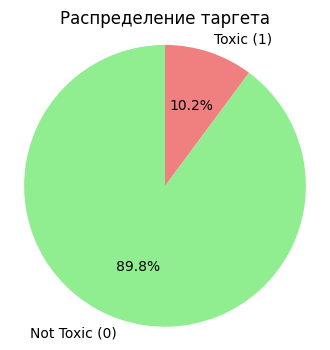

In [17]:
toxic_counts = df['toxic'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(toxic_counts,
        labels=['Not Toxic (0)', 'Toxic (1)'],
        colors=['lightgreen', 'lightcoral'],
        autopct='%1.1f%%',
        startangle=90)
plt.axis('equal')
plt.title('Распределение таргета')
plt.show()

Видим довольно большой дизбаланс.

### 2.6. <a id='toc2_6_'></a>Выводы по датасету        [&#8593;](#toc0_)

Перед нами датасет о комментариях с оценкой их токсичности. Пропуски не обнаружены. Полные дубликаты также не обнаружены. Распределение целевого признака крайне несбалансированное. Записей с таргетом `0` (not toxic) почти в 9 раз больше.

## 3. <a id='toc3_'></a>Обработка текста        [&#8593;](#toc0_)

In [18]:
def clean_text(text: str) -> str:
    text = re.sub(r"[^a-zA-Z\s']", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()

    return text

In [19]:
lemmatized_path = './data/lemmatized.csv'

if exists(lemmatized_path):
    df = pd.read_csv(lemmatized_path)
else:
    disabled_pipes = ['parser',  'ner']
    nlp = spacy.load('en_core_web_md', disable=disabled_pipes)
    texts = df['text'].apply(clean_text).tolist()
    lemm_texts = []

    for doc in tqdm(nlp.pipe(texts, disable=disabled_pipes), total=len(texts)):
        lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        lemm_text = ' '.join(lemmas)
        lemm_texts.append(lemm_text)

    df['text'] = lemm_texts

    Path('./data').mkdir(exist_ok=True)
    df.to_csv('./data/lemmatized.csv', index=False)

In [20]:
df.head()

,text,toxic
0,explanation edit username hardcore metallica f...,0
1,d'aww match background colour seemingly stuck ...,0
2,hey man try edit war guy constantly remove rel...,0
3,real suggestion improvement wonder section sta...,0
4,sir hero chance remember page,0


## 4. <a id='toc4_'></a>Модели        [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Разделение данных        [&#8593;](#toc0_)

In [21]:
X = df['text']
y = df['toxic']

In [22]:
X = X.astype('str')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

In [24]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(143362,) (15930,)
(143362,) (15930,)


### 4.2. <a id='toc4_2_'></a>Подготовка       [&#8593;](#toc0_)

In [25]:
def get_objective(estimator,
                  X_train: pd.DataFrame,
                  y_train: pd.Series):
    def objective(params: dict) -> float:
        """Кросс-валидация с текущими гиперпараметрами.

        Args:
            estimator: пайплайн с моделью или отдельно модель
            params (dict): гиперпараметры
            X_train (pd.DataFrame): входные признаки (features)
            y_train (pd.Series): целевой признак (target)

        Returns:
            dict: Словарь со средним значением метрики, гиперпараметрами и статусом.
        """
        # Некоторые параметры могут быть только целочисленные, приводим их к нужному типу
        for key, value in params.items():
            if isinstance(value, float) and value % 1 == 0:
                params[key] = int(value)

        estimator.set_params(**params)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

        try:
            score = cross_val_score(estimator=estimator,
                                    X=X_train,
                                    y=y_train,
                                    scoring='f1',
                                    cv=skf,
                                    n_jobs=-1)

            return {
                'loss': -score.mean(),
                'params': params,
                'status': STATUS_OK
            }
        except Exception as e:
            print(e)
            return {'status': STATUS_FAIL}

    return objective

In [26]:
def get_model_results(estimator,
                      param_space: dict,
                      X_train: pd.DataFrame,
                      y_train: pd.Series,
                      max_evals: int = 1000
                      ) -> tuple[dict, float]:
    objective = get_objective(estimator, X_train, y_train)
    trials = Trials()

    fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(RANDOM_STATE),
        show_progressbar=True
    )

    clear_output()

    best_params = trials.best_trial['result']['params']
    best_score = abs(trials.best_trial['result']['loss'])
    print(f'Finish with best F1 = {best_score:.4f}')

    return best_params, best_score

### 4.3. <a id='toc4_3_'></a>Модель `LogisticRegression`       [&#8593;](#toc0_)

In [27]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1, max_iter=1000))
])

In [28]:
param_space = {
    'tfidf__max_features':       hp.quniform('tfidf__max_features', 30_000, 50_000, 1000),       # Максимальное количество признаков (целые числа)
    'tfidf__min_df':             hp.choice('tfidf__min_df', [1, 2, 5, 10]),                      # Минимальная частота слов в документах
    'tfidf__max_df':             hp.uniform('tfidf__max_df', 0.7, 1.0),                          # Максимальная частота слов в документах
    'tfidf__use_idf':            hp.choice('tfidf__use_idf', [True, False]),                     # Использовать обратную частоту документа
    'tfidf__smooth_idf':         hp.choice('tfidf__smooth_idf', [True, False]),                  # Сглаживать IDF веса
    'tfidf__sublinear_tf':       hp.choice('tfidf__sublinear_tf', [True, False]),                # Применять сублинейное масштабирование TF

    'model__C':                  hp.loguniform('model__C', np.log(1e-3), np.log(15)),            # Обратная сила регуляризации (log-scale)
    'model__class_weight':       hp.choice('model__class_weight', [None, 'balanced']),           # Вес классов (автоматический баланс или нет)
}

In [29]:
# best_params_lr, best_score_lr = get_model_results(lr_pipeline, param_space, X_train, y_train, 100)

In [30]:
best_params_lr = {
    'model__C': 14.848553211901166,
    'model__class_weight': None,
    'tfidf__max_df': 0.7549417960132765,
    'tfidf__max_features': 37000,
    'tfidf__min_df': 5,
    'tfidf__smooth_idf': True,
    'tfidf__sublinear_tf': True,
    'tfidf__use_idf': False
}

In [31]:
best_score_lr = 0.7859790770261292

### 4.4. <a id='toc4_4_'></a>Модель `RandomForestClassifier`      [&#8593;](#toc0_)

In [32]:
rfc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

In [33]:
param_space = {
    'tfidf__max_features':       hp.quniform('tfidf__max_features', 30_000, 50_000, 1000),   # Максимальное количество признаков (целые числа)
    'tfidf__min_df':             hp.choice('tfidf__min_df', [1, 2, 5, 10]),                  # Минимальная частота слов в документах
    'tfidf__max_df':             hp.uniform('tfidf__max_df', 0.7, 1.0),                      # Максимальная частота слов в документах
    'tfidf__use_idf':            hp.choice('tfidf__use_idf', [True, False]),                 # Использовать обратную частоту документа
    'tfidf__smooth_idf':         hp.choice('tfidf__smooth_idf', [True, False]),              # Сглаживать IDF веса
    'tfidf__sublinear_tf':       hp.choice('tfidf__sublinear_tf', [True, False]),            # Применять сублинейное масштабирование TF

    'model__n_estimators':       hp.choice('model__n_estimators', [50, 100, 200, 500]),      # Количество деревьев в лесу
    'model__criterion':          hp.choice('model__criterion', ['gini', 'entropy']),         # Критерий качества разбиения
    'model__max_depth':          hp.choice('model__max_depth', [None, 10, 20, 30, 50]),      # Максимальная глубина дерева
    'model__min_samples_split':  hp.choice('model__min_samples_split', [2, 5, 10]),          # Минимальное число объектов для разбиения
    'model__min_samples_leaf':   hp.choice('model__min_samples_leaf', [1, 2, 4]),            # Минимальное число объектов в листе
    'model__bootstrap':          hp.choice('model__bootstrap', [True, False]),               # Использовать бутстрэп выборки
    'model__class_weight':       hp.choice('model__class_weight', [None, 'balanced']),       # Веса классов для несбалансированных данных
}

In [34]:
# best_params_rfc, best_score_rfc = get_model_results(rfc_pipeline, param_space, X_train, y_train, 100)

In [35]:
best_params_rfc = {
    'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'gini',
    'model__max_depth': None,
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 2,
    'model__n_estimators': 200,
    'tfidf__max_df': 0.7653612620932736,
    'tfidf__max_features': 46000,
    'tfidf__min_df': 10,
    'tfidf__smooth_idf': True,
    'tfidf__sublinear_tf': True,
    'tfidf__use_idf': False
 }

In [36]:
best_score_rfc = 0.7645131020400102

### 4.5. <a id='toc4_5_'></a>Модель `LGBMClassifier`      [&#8593;](#toc0_)

In [37]:
lgbmc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1))
])

In [38]:
param_space = {
    'tfidf__max_features':       hp.quniform('tfidf__max_features', 30_000, 50_000, 1000),       # Максимальное количество признаков (целые числа)
    'tfidf__min_df':             hp.choice('tfidf__min_df', [1, 2, 5, 10]),                      # Минимальная частота слов в документах
    'tfidf__max_df':             hp.uniform('tfidf__max_df', 0.7, 1.0),                          # Максимальная частота слов в документах
    'tfidf__use_idf':            hp.choice('tfidf__use_idf', [True, False]),                     # Использовать обратную частоту документа
    'tfidf__smooth_idf':         hp.choice('tfidf__smooth_idf', [True, False]),                  # Сглаживать IDF веса
    'tfidf__sublinear_tf':       hp.choice('tfidf__sublinear_tf', [True, False]),                # Применять сублинейное масштабирование TF

    'model__boosting_type':      hp.choice('model__boosting_type', ['gbdt', 'dart', 'goss']),    # Тип бустинга
    'model__num_leaves':         hp.quniform('model__num_leaves', 10, 200, 1),                   # Количество листьев в дереве
    'model__learning_rate':      hp.loguniform('model__learning_rate', -5, 0),                   # Скорость обучения
    'model__n_estimators':       hp.quniform('model__n_estimators', 50, 500, 1),                 # Количество деревьев
    'model__subsample':          hp.uniform('model__subsample', 0.5, 1.0),                       # Доля выборки для обучения каждого дерева
    'model__colsample_bytree':   hp.uniform('model__colsample_bytree', 0.5, 1.0),                # Доля признаков для каждого дерева
    'model__reg_alpha':          hp.loguniform('model__reg_alpha', -5, 2),                       # L1-регуляризация
    'model__reg_lambda':         hp.loguniform('model__reg_lambda', -5, 2),                      # L2-регуляризация
    'model__min_child_samples':  hp.quniform('model__min_child_samples', 5, 100, 1),             # Минимальное количество объектов в листе
    'model__max_depth':          hp.choice('model__max_depth', [-1, 3, 5, 7, 10]),               # Максимальная глубина дерева (-1 = без ограничений)
}

In [39]:
# best_params_lgbmc, best_score_lgbmc = get_model_results(lgbmc_pipeline, param_space, X_train, y_train, 100)

In [40]:
best_params_lgbmc = {
    'model__boosting_type': 'gbdt',
    'model__colsample_bytree': 0.6191104272221566,
    'model__learning_rate': 0.09230661681722988,
    'model__max_depth': -1,
    'model__min_child_samples': 22,
    'model__n_estimators': 298,
    'model__num_leaves': 89,
    'model__reg_alpha': 0.8456632205247746,
    'model__reg_lambda': 0.12795690362150944,
    'model__subsample': 0.5637403699663865,
    'tfidf__max_df': 0.9783133591194336,
    'tfidf__max_features': 34000,
    'tfidf__min_df': 2,
    'tfidf__smooth_idf': True,
    'tfidf__sublinear_tf': True,
    'tfidf__use_idf': False
}

In [41]:
best_score_lgbmc = 0.7781002572293113

### 4.6. <a id='toc4_6_'></a>Модель `CatBoostClassifier`      [&#8593;](#toc0_)

In [42]:
cbc = CatBoostClassifier(random_state=RANDOM_STATE,
                         silent=True,
                         text_features=[0])

In [43]:
X_train_df = X_train.to_frame()
X_test_df = X_test.to_frame()

In [44]:
param_space = {
    'learning_rate':        hp.uniform('learning_rate', 0.01, 0.3),    # Скорость обучения модели
    'depth':                hp.randint('depth', 6, 12),                # Глубина деревьев в ансамбле
    'l2_leaf_reg':          hp.uniform('l2_leaf_reg', 1, 10),          # Регуляризация L2 для предотвращения переобучения
    'bagging_temperature':  hp.uniform('bagging_temperature', 0, 2),   # Температура баггинга для случайности выборки
    'random_strength':      hp.uniform('random_strength', 0, 2),       # Сила случайности при выборе разбиений
    'iterations':           hp.randint('iterations', 500, 1500),       # Количество итераций обучения
}

In [45]:
class DillTrials(Trials):
    def __init__(self, *args, **kwargs):
        super(DillTrials, self).__init__(*args, **kwargs)

    def _dump(self, trials_data):
        return dill.dumps(trials_data)

    def _load(self, dumped_trials_data):
        return dill.loads(dumped_trials_data)

In [46]:
def get_catboost_results(estimator,
                         param_space: dict,
                         X_train: pd.DataFrame,
                         y_train: pd.Series,
                         max_evals: int = 1000
                         ) -> tuple[dict, float]:
    objective = get_objective(estimator, X_train, y_train)
    trials = DillTrials()

    fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(RANDOM_STATE),
        show_progressbar=True
    )

    clear_output()

    best_params = trials.best_trial['result']['params']
    best_score = abs(trials.best_trial['result']['loss'])
    print(f'Finish with best F1 = {best_score:.4f}')

    return best_params, best_score

In [47]:
# best_params_cbc, best_score_cbc = get_catboost_results(cbc, param_space, X_train_df, y_train, 10)

In [ ]:
best_params_cbc = {
    'bagging_temperature': 1.7389111572038438,
    'depth': 11,
    'iterations': 1064,
    'l2_leaf_reg': 3.3165007466765335,
    'learning_rate': 0.15070800692707131,
 'random_strength': 1.7395298918827333
}

In [49]:
best_score_cbc = 0.7747741394866509

### 4.7. <a id='toc4_7_'></a>Модель `BERT`   [&#8593;](#toc0_)

In [50]:
EPOCHS = 3
BATCH_SIZE = 16
MAX_SEQ_LENGTH = 128

In [51]:
model_name = 'distilbert-base-uncased'

In [52]:
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

In [53]:
def tokenize_data(texts, labels):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_SEQ_LENGTH,
        return_tensors="pt"
    )
    encodings['labels'] = torch.tensor(labels)

    return encodings

In [54]:
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(X_train,
                                                                      y_train,
                                                                      test_size=TEST_SIZE,
                                                                      random_state=RANDOM_STATE,
                                                                      stratify=y_train)

In [55]:
train_encodings = tokenize_data(X_train_bert.values.tolist(), y_train_bert.values.tolist())
val_encodings = tokenize_data(X_val_bert.values.tolist(), y_val_bert.values.tolist())

In [56]:
class ToxicityDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [57]:
train_dataset = ToxicityDataset(train_encodings)
val_dataset = ToxicityDataset(val_encodings)

In [58]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(colored('GPU найден. Будет использован GPU.', 'green'))
else:
    print(colored('GPU не найден. Будет использован CPU.', 'red'))

GPU найден. Будет использован GPU.


In [60]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device);

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [62]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Обучающий режим
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=True)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({'Batch Loss': f'{loss.item():.4f}'})

    avg_train_loss = train_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.4f}")
    
    # Валидационный режим
    model.eval()
    all_predictions = []
    all_labels = []
    val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", leave=True)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            val_loss += loss.item()
            _, predicted = torch.max(logits, dim=1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Вычисление F1-score
            f1 = f1_score(all_labels, all_predictions, average='binary')
            progress_bar.set_postfix({'F1 Score': f'{f1:.4f}'})

    avg_val_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_predictions, average='binary')
    print(f"Average validation loss: {avg_val_loss:.4f}, F1 Score: {f1:.4f}")

Epoch 1/3


Training Epoch 1:   0%|          | 0/8065 [00:00<?, ?it/s]

Average training loss: 0.1086


Validation Epoch 1:   0%|          | 0/897 [00:00<?, ?it/s]

Average validation loss: 0.0931, F1 Score: 0.8261
Epoch 2/3


Training Epoch 2:   0%|          | 0/8065 [00:00<?, ?it/s]

Average training loss: 0.0751


Validation Epoch 2:   0%|          | 0/897 [00:00<?, ?it/s]

Average validation loss: 0.1113, F1 Score: 0.8086
Epoch 3/3


Training Epoch 3:   0%|          | 0/8065 [00:00<?, ?it/s]

Average training loss: 0.0470


Validation Epoch 3:   0%|          | 0/897 [00:00<?, ?it/s]

Average validation loss: 0.1154, F1 Score: 0.8179


Получим финальную метрику на валидационной выборке.

In [63]:
f1_metric = F1Score(task="binary").to(device)

In [64]:
model.eval();

In [65]:
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating on Validation Set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Получение предсказаний модели
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)
        
        # Обновление метрик
        f1_metric.update(predicted, labels)

Evaluating on Validation Set:   0%|          | 0/897 [00:00<?, ?it/s]

In [66]:
f1_bert = f1_metric.compute()
print(f"F1 Score: {f1_bert:.4f}")

F1 Score: 0.8179


Модель BERT показала неплохой результат. С небольшим отрывом она обогнала все "классические" модели.

### 4.8. <a id='toc4_8_'></a>Модель `toxic-BERT`  [&#8593;](#toc0_)

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(colored('GPU найден. Будет использован GPU.', 'green'))
else:
    print(colored('GPU не найден. Будет использован CPU.', 'red'))

GPU найден. Будет использован GPU.


In [68]:
model_name = "unitary/toxic-bert"

In [69]:
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)

In [70]:
def tokenize_data(texts):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=MAX_SEQ_LENGTH,
        return_tensors="pt"
    )
    return encodings

In [71]:
class ToxicityDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [72]:
train_encodings = tokenize_data(X_train_bert.values.tolist())
val_encodings = tokenize_data(X_val_bert.values.tolist())

In [73]:
train_dataset = ToxicityDataset(train_encodings)
val_dataset = ToxicityDataset(val_encodings)

In [74]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [75]:
def extract_features(loader):
    model.eval()
    all_features = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting Features"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Получение эмбеддингов последнего слоя
            outputs = model(input_ids, attention_mask=attention_mask)
            features = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS] токен
            
            all_features.extend(features)
    return all_features

In [76]:
print("Extracting features from training data...")
train_features = extract_features(train_loader)

Extracting features from training data...


Extracting Features:   0%|          | 0/8065 [00:00<?, ?it/s]

In [77]:
print("Extracting features from validation data...")
val_features = extract_features(val_loader)

Extracting features from validation data...


Extracting Features:   0%|          | 0/897 [00:00<?, ?it/s]

In [78]:
log_reg = LogisticRegression(max_iter=1000,
                             solver='liblinear',
                             random_state=RANDOM_STATE,
                             n_jobs=-1)
log_reg.fit(train_features, y_train_bert);

In [79]:
y_pred = log_reg.predict(val_features)

In [80]:
f1_toxic_bert = f1_score(y_val_bert, y_pred, average='binary')
print(f'F1 = {f1_toxic_bert:.4f}')

F1 = 0.8458


## 5. <a id='toc5_'></a>Результаты      [&#8593;](#toc0_)

### 5.1. <a id='toc5_1_'></a>Результаты на тренировочной выборке      [&#8593;](#toc0_)

In [81]:
pd.options.display.float_format = '{:.4f}'.format

pd.DataFrame(
    data=[best_score_rfc, best_score_cbc, best_score_lgbmc, best_score_lr, float(f1_bert.cpu()), f1_toxic_bert],
    index=['RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier', 'LogisticRegression', 'BERT', 'toxic-BERT'],
    columns=['f1']
).sort_values('f1', ascending=True)

,f1
RandomForestClassifier,0.7645
CatBoostClassifier,0.7748
LGBMClassifier,0.7781
LogisticRegression,0.7860
BERT,0.8179
toxic-BERT,0.8458


Лучше всех себя показал toxic-BERT - именно он и будет проверен на тестовой выборке.

### 5.2. <a id='toc5_2_'></a>Результаты на тестовой выборке      [&#8593;](#toc0_)

In [82]:
test_encodings = tokenize_data(X_test.values.tolist())

In [83]:
test_dataset = ToxicityDataset(test_encodings)

In [84]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [85]:
test_features = extract_features(test_loader)

Extracting Features:   0%|          | 0/996 [00:00<?, ?it/s]

In [86]:
y_pred = log_reg.predict(test_features)

In [87]:
f1 = f1_score(y_test, y_pred, average='binary')
print(f'F1 on test = {f1:.4f}')

F1 on test = 0.8661


In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14311
           1       0.90      0.83      0.87      1619

    accuracy                           0.97     15930
   macro avg       0.94      0.91      0.93     15930
weighted avg       0.97      0.97      0.97     15930



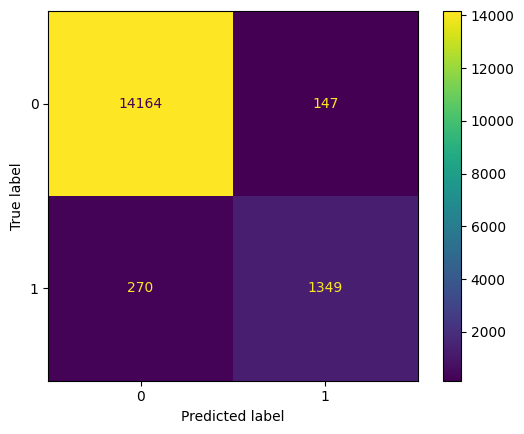

In [89]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

## 6. <a id='toc6_'></a>Общий вывод      [&#8593;](#toc0_)

В рамках данного проекта мы работали с задачей обработки естественного языка (NLP), а именно определение токсичности комментариев (бинарная классификация).

Перед нами датасет, состоящий практически практически из `160 000` записей. Он [датасет] не содержит пропусков и полных дубликатов. Также отметим дизбаланс примерно `9:1` в сторону не токсичных комментариев (класс `0`).

Сначала текст был очищен с помощью регулярных выражений, а также лемматизирован.

Были протестированы 4 различные модели с подбором гиперпараметров через *hyperopt*, а именно: *LogisticRegression*, *RandomForestClassifier*, *LGBMClassifier* и *CatBoostClassifier*. Для первых трёх моделей был использован *TfidfVectorizer*, гиперпараметры которого подбирались также через *hyperopt*. А вот *CatBoostClassifier* умеет работать с текстовыми признаками "из коробки", что и было использовано.

Результаты представлены в таблице ниже:

|          Model         |   F1   |
|:----------------------:|:------:|
| RandomForestClassifier | 0.7645 |
| CatBoostClassifier     | 0.7748 |
| LGBMClassifier         | 0.7781 |
| LogisticRegression     | 0.7860 |
| BERT                   | 0.8179 |
| toxic-BERT             | 0.8458 |


Из этих 4 "классических" моделей лучше всего себя показала *LogisticRegression* с результатом `F1 = 0.7860`.

Также была протестирована предобученная (distilbert-base-uncased) модель *BERT*. Она показала неплохой результат, обходящий все "классические" модели.

Последней была протестирована модель *toxic-BERT*. Однако ее дообучение не проводилось. Был использован только бэкбон для получения эмбеддингов, а в качестве классификатора была использована *LogisticRegression*. Данная связка показала также неплохой результат - `F1 = 0.8458`.

Именно она и была протестирована на тестовой подвыборке и показала результат `F1 = 0.8661`. Это больше минимально необходимой метрики, следовательно проект можно считать успешным.